<a href="https://colab.research.google.com/github/sruthikoyya/SummerIntership_NITR/blob/main/UNet_NITR_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q torchmetrics torchvision

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import OxfordIIITPet
import torchvision.transforms.functional as TF

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, jaccard_score

import os
from PIL import Image


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 62.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 42.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 81.9 MB/s eta 0:00:00


In [ ]:
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Resize
import torchvision.transforms.functional as TF
import os

class PetDataset(Dataset):
    def __init__(self, root, image_size=128):
        self.dataset = OxfordIIITPet(root, download=True, target_types="segmentation")
        self.image_size = image_size

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image, mask = self.dataset[idx]

        # Resize
        image = TF.resize(image, (self.image_size, self.image_size))
        mask = TF.resize(mask, (self.image_size, self.image_size))

        # Convert to tensor
        image = TF.to_tensor(image)
        mask = torch.as_tensor(np.array(mask), dtype=torch.int64)

        # The mask has 3 classes: 0 = background, 1 = foreground, 2 = border
        # We'll turn it into binary mask: 1 for pet, 0 for background/border
        mask = (mask == 1).float().unsqueeze(0)  # Shape: (1, H, W)

        return image, mask


In [ ]:
image_size = 128
dataset = PetDataset(root="./data", image_size=image_size)

# Split into training and validation sets
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_ds, val_ds = torch.utils.data.random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)


100%|██████████| 792M/792M [00:34<00:00, 23.3MB/s]
100%|██████████| 19.2M/19.2M [00:01<00:00, 10.6MB/s]


In [ ]:
# Split: 70% train, 15% val, 15% test
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_ds, val_ds, test_ds = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

train_loader = DataLoader(train_ds, batch_size=8, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=8, shuffle=False)
test_loader = DataLoader(test_ds, batch_size=8, shuffle=False)


In [ ]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels,dropout=0.2):
        super(DoubleConv, self).__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.double_conv(x)

In [ ]:
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1,dropout=0.2):
        super(UNet, self).__init__()

        self.down1 = DoubleConv(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)
        self.down2 = DoubleConv(64, 128,dropout)
        self.pool2 = nn.MaxPool2d(2)
        self.down3 = DoubleConv(128, 256,dropout)
        self.pool3 = nn.MaxPool2d(2)
        self.down4 = DoubleConv(256, 512,dropout)
        self.pool4 = nn.MaxPool2d(2)

        self.middle = DoubleConv(512, 1024)

        self.up4 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.up_conv4 = DoubleConv(1024, 512,dropout)
        self.up3 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.up_conv3 = DoubleConv(512, 256,dropout)
        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.up_conv2 = DoubleConv(256, 128,dropout)
        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.up_conv1 = DoubleConv(128, 64,dropout)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        d1 = self.down1(x)
        d2 = self.down2(self.pool1(d1))
        d3 = self.down3(self.pool2(d2))
        d4 = self.down4(self.pool3(d3))
        m = self.middle(self.pool4(d4))

        u4 = self.up4(m)
        u4 = torch.cat([u4, d4], dim=1)
        u4 = self.up_conv4(u4)

        u3 = self.up3(u4)
        u3 = torch.cat([u3, d3], dim=1)
        u3 = self.up_conv3(u3)

        u2 = self.up2(u3)
        u2 = torch.cat([u2, d2], dim=1)
        u2 = self.up_conv2(u2)

        u1 = self.up1(u2)
        u1 = torch.cat([u1, d1], dim=1)
        u1 = self.up_conv1(u1)

        return torch.sigmoid(self.final(u1))


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = UNet(in_channels=3, out_channels=1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.BCELoss()  # Binary segmentation uses Binary Cross-Entropy


In [ ]:
def train(model, dataloader, optimizer, criterion):
    model.train()
    epoch_loss = 0
    correct_pixels = 0
    total_pixels = 0

    for images, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        preds = model(images)
        loss = criterion(preds, masks)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        preds_binary = (preds > 0.5).float()
        correct_pixels += (preds_binary == masks).sum().item()
        total_pixels += torch.numel(preds)

    accuracy = correct_pixels / total_pixels
    return epoch_loss / len(dataloader), accuracy

def validate(model, dataloader, criterion):
    model.eval()
    val_loss = 0
    correct_pixels = 0
    total_pixels = 0

    with torch.no_grad():
        for images, masks in dataloader:
            images, masks = images.to(device), masks.to(device)
            preds = model(images)
            loss = criterion(preds, masks)
            val_loss += loss.item()

            preds_binary = (preds > 0.5).float()
            correct_pixels += (preds_binary == masks).sum().item()
            total_pixels += torch.numel(preds)

    accuracy = correct_pixels / total_pixels
    return val_loss / len(dataloader), accuracy


In [ ]:
num_epochs = 20
train_losses, val_losses = [], []
train_accs, val_accs = [], []

for epoch in range(num_epochs):
    train_loss, train_acc = train(model, train_loader, optimizer, criterion)
    val_loss, val_acc = validate(model, val_loader, criterion)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    print(f"Epoch {epoch+1}/{num_epochs} | "
          f"Train Loss: {train_loss:.4f}, Accuracy: {train_acc:.4f} | "
          f"Val Loss: {val_loss:.4f}, Accuracy: {val_acc:.4f}")


Epoch 1/20 | Train Loss: 0.5379, Accuracy: 0.7176 | Val Loss: 0.4347, Accuracy: 0.8101
Epoch 2/20 | Train Loss: 0.3835, Accuracy: 0.8268 | Val Loss: 0.3885, Accuracy: 0.8458
Epoch 3/20 | Train Loss: 0.3167, Accuracy: 0.8624 | Val Loss: 0.3043, Accuracy: 0.8776
Epoch 4/20 | Train Loss: 0.2787, Accuracy: 0.8854 | Val Loss: 0.2854, Accuracy: 0.8811
Epoch 5/20 | Train Loss: 0.2527, Accuracy: 0.8966 | Val Loss: 0.2597, Accuracy: 0.8886
Epoch 6/20 | Train Loss: 0.2335, Accuracy: 0.9054 | Val Loss: 0.2578, Accuracy: 0.8873
Epoch 7/20 | Train Loss: 0.2183, Accuracy: 0.9114 | Val Loss: 0.2401, Accuracy: 0.9008
Epoch 8/20 | Train Loss: 0.2038, Accuracy: 0.9168 | Val Loss: 0.2712, Accuracy: 0.8903
Epoch 9/20 | Train Loss: 0.1968, Accuracy: 0.9205 | Val Loss: 0.2740, Accuracy: 0.8904
Epoch 10/20 | Train Loss: 0.1833, Accuracy: 0.9263 | Val Loss: 0.2460, Accuracy: 0.9034
Epoch 11/20 | Train Loss: 0.1745, Accuracy: 0.9294 | Val Loss: 0.2147, Accuracy: 0.9116
Epoch 12/20 | Train Loss: 0.1666, Accurac

In [ ]:
def compute_metrics(model, dataloader):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            masks = masks.to(device)

            preds = model(images)
            preds = (preds > 0.5).float()

            all_preds.extend(preds.cpu().numpy().reshape(-1))
            all_targets.extend(masks.cpu().numpy().reshape(-1))

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    acc = accuracy_score(all_targets, all_preds)
    iou = jaccard_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    dice = 2 * (iou * acc) / (iou + acc + 1e-7)
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)

    print(f"\n📊 Evaluation Metrics on Validation Set:")
    print(f"Accuracy  : {acc:.4f}")
    print(f"IoU       : {iou:.4f}")
    print(f"Dice      : {dice:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1 Score  : {f1:.4f}")


In [ ]:
compute_metrics(model, val_loader)



📊 Evaluation Metrics on Validation Set:
Accuracy  : 0.9125
IoU       : 0.7234
Dice      : 0.8071
Precision : 0.8763
Recall    : 0.8057
F1 Score  : 0.8395


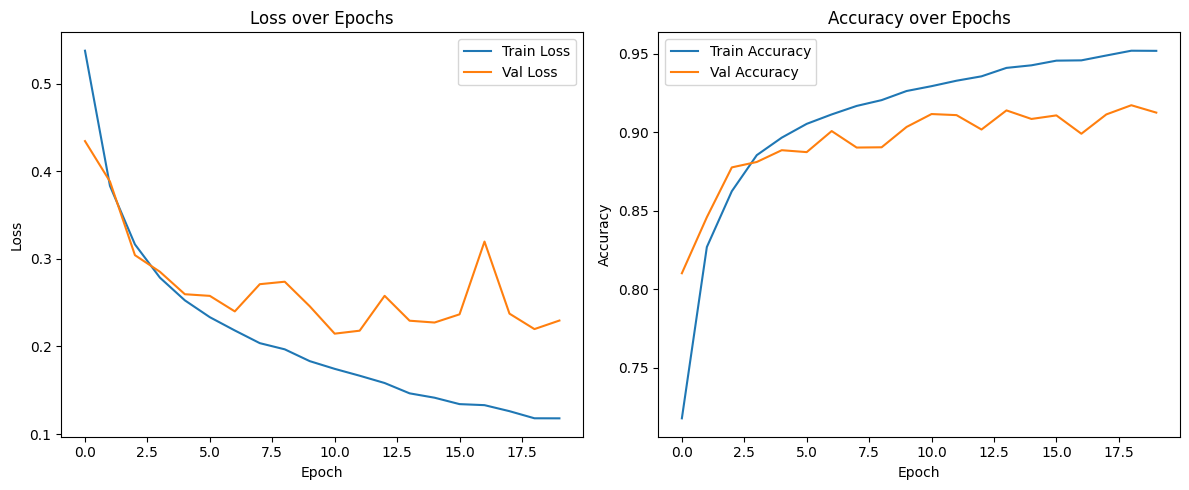

In [ ]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.title("Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accs, label="Train Accuracy")
plt.plot(val_accs, label="Val Accuracy")
plt.title("Accuracy over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
def show_predictions(model, dataloader, num_samples=3):
    model.eval()
    count = 0

    for images, masks in dataloader:
        images = images.to(device)
        with torch.no_grad():
            preds = model(images)
            preds = (preds > 0.5).float()

        for i in range(images.shape[0]):
            if count >= num_samples:
                return

            image = images[i].cpu().permute(1, 2, 0).numpy()
            mask = masks[i].cpu().squeeze().numpy()
            pred = preds[i].cpu().squeeze().numpy()

            plt.figure(figsize=(12, 3))
            plt.subplot(1, 3, 1)
            plt.imshow(image)
            plt.title("Image")
            plt.axis("off")

            plt.subplot(1, 3, 2)
            plt.imshow(mask, cmap="gray")
            plt.title("Ground Truth")
            plt.axis("off")

            plt.subplot(1, 3, 3)
            plt.imshow(pred, cmap="gray")
            plt.title("Prediction")
            plt.axis("off")

            plt.show()
            count += 1


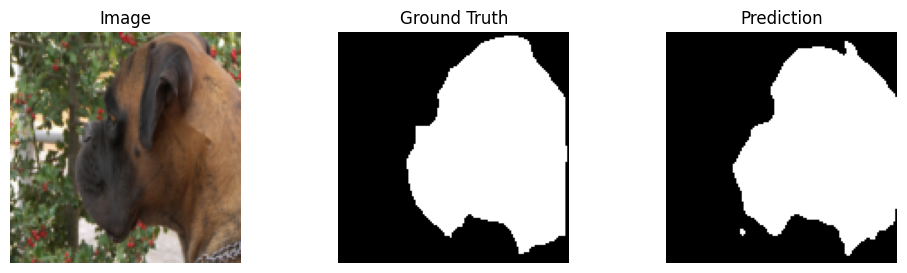

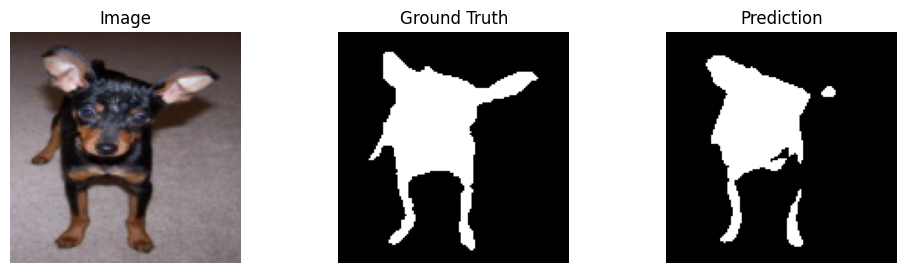

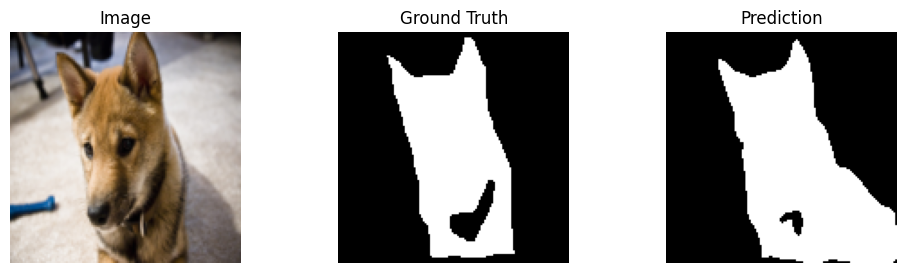

In [ ]:
show_predictions(model, val_loader)


In [ ]:
def evaluate_on_test(model, test_loader):
    model.eval()
    all_preds = []
    all_targets = []

    with torch.no_grad():
        for images, masks in test_loader:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            preds = (outputs > 0.5).float()

            all_preds.extend(preds.cpu().numpy().reshape(-1))
            all_targets.extend(masks.cpu().numpy().reshape(-1))

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    acc = accuracy_score(all_targets, all_preds)
    iou = jaccard_score(all_targets, all_preds, zero_division=0)
    f1 = f1_score(all_targets, all_preds, zero_division=0)
    dice = 2 * (iou * acc) / (iou + acc + 1e-7)
    precision = precision_score(all_targets, all_preds, zero_division=0)
    recall = recall_score(all_targets, all_preds, zero_division=0)

    print("\nTest Set Evaluation:")
    print(f"Accuracy  : {acc:.4f}")
    print(f"IoU       : {iou:.4f}")
    print(f"Dice      : {dice:.4f}")
    print(f"Precision : {precision:.4f}")
    print(f"Recall    : {recall:.4f}")
    print(f"F1 Score  : {f1:.4f}")


In [ ]:
evaluate_on_test(model, test_loader)



📊 Test Set Evaluation:
Accuracy  : 0.9346
IoU       : 0.7893
Dice      : 0.8558
Precision : 0.9180
Recall    : 0.8491
F1 Score  : 0.8822
